# Bitcoin Feasibility Analysis for CHAOS Strategy

Compares CHAOS performance under three deployment scenarios:
1. Cardano (baseline) — low tx costs, native stablecoin, high LP APY
2. Bitcoin L2 (Stacks/Liquid) — moderate tx costs, wrapped stablecoins, moderate LP
3. Bitcoin L1 (DLC/multisig) — high tx costs, WBTC-based, minimal LP

Also compares BTC vs ADA as the volatile asset.

In [1]:
%matplotlib inline

"""
Bitcoin Feasibility Analysis for CHAOS Strategy

Compares CHAOS performance under three deployment scenarios:
  1. Cardano (baseline) — low tx costs, native stablecoin, high LP APY
  2. Bitcoin L2 (Stacks/Liquid) — moderate tx costs, wrapped stablecoins, moderate LP
  3. Bitcoin L1 (DLC/multisig) — high tx costs, WBTC-based, minimal LP

Also compares BTC vs ADA as the volatile asset (using the same strategy).

Usage:
    python simulations/bitcoin_feasibility.py
"""

import numpy as np
import matplotlib.pyplot as plt
import json
import os
from dataclasses import dataclass, field
from typing import List, Dict, Tuple

# ──────────────────────────────────────────────────────────────
# Configuration: Deployment scenarios
# ──────────────────────────────────────────────────────────────

@dataclass
class DeploymentConfig:
    """Parameters for a specific blockchain deployment."""
    name: str
    tx_cost_pct: float        # % of trade volume per rebalance
    tx_fixed_usd: float       # fixed $ cost per rebalance tx
    lp_apy: float             # realistic LP APY for the chain
    min_rebalance_usd: float  # minimum trade size to be worth it
    confirmation_minutes: int  # avg time to finality
    stablecoin_depeg_risk: float  # probability of >2% depeg per year
    has_native_stablecoin: bool
    description: str

CARDANO = DeploymentConfig(
    name="Cardano (EUTXO)",
    tx_cost_pct=0.004,       # 0.4% DEX + slippage
    tx_fixed_usd=0.40,       # ~0.8 ADA tx fee
    lp_apy=0.20,             # ADA/DJED LP ~20%
    min_rebalance_usd=50,
    confirmation_minutes=1,   # 20s block, ~3 confirmations
    stablecoin_depeg_risk=0.05,
    has_native_stablecoin=True,
    description="Native EUTXO smart contracts, Aiken, DJED stablecoin"
)

BITCOIN_L2 = DeploymentConfig(
    name="Bitcoin L2 (Stacks)",
    tx_cost_pct=0.006,       # 0.6% — higher DEX fees on Stacks
    tx_fixed_usd=1.50,       # Stacks tx fee + STX gas
    lp_apy=0.08,             # sBTC/USDC LP, lower liquidity
    min_rebalance_usd=100,
    confirmation_minutes=10,  # Stacks blocks ~10 min
    stablecoin_depeg_risk=0.10,  # wrapped USDC, bridge risk
    has_native_stablecoin=False,
    description="Clarity smart contracts on Stacks, sBTC, bridged USDC"
)

BITCOIN_L1 = DeploymentConfig(
    name="Bitcoin L1 (DLC)",
    tx_cost_pct=0.003,       # 0.3% — OTC/atomic swap, lower slippage
    tx_fixed_usd=15.00,      # ~$15 avg BTC tx fee (moderate congestion)
    lp_apy=0.02,             # minimal — no native DEXs, must use DLCs
    min_rebalance_usd=500,   # not worth it for small amounts
    confirmation_minutes=60,  # 6 confirmations × 10 min
    stablecoin_depeg_risk=0.15,  # WBTC/tBTC trust assumptions
    has_native_stablecoin=False,
    description="DLC oracles + multisig, no smart contracts, WBTC-based"
)


# ──────────────────────────────────────────────────────────────
# Price generation — realistic BTC and ADA returns
# ──────────────────────────────────────────────────────────────

def generate_price_series(
    asset: str,
    n_days: int = 730,
    seed: int = 42
) -> np.ndarray:
    """
    Generate realistic price series using regime-switching model.
    Calibrated to actual historical volatility characteristics.
    """
    rng = np.random.default_rng(seed)

    if asset == "BTC":
        # BTC: ~60% ann vol, occasional 30-40% crashes, strong recoveries
        base_vol = 0.035       # daily vol (~60% ann)
        crash_prob = 0.008     # ~3 crashes per year
        crash_size = -0.12     # avg crash: -12% in a day
        drift = 0.0003         # slight positive drift (~11% ann)
        mean_revert = 0.002    # mild mean reversion
        start_price = 42000
    elif asset == "ADA":
        # ADA: ~85% ann vol, deeper crashes, more volatile
        base_vol = 0.050       # daily vol (~85% ann)
        crash_prob = 0.012     # ~4 crashes per year
        crash_size = -0.15     # avg crash: -15%
        drift = 0.0001         # very slight positive drift
        mean_revert = 0.003
        start_price = 0.55
    else:
        raise ValueError(f"Unknown asset: {asset}")

    prices = np.zeros(n_days)
    prices[0] = start_price
    log_prices = np.zeros(n_days)
    log_prices[0] = np.log(start_price)

    for i in range(1, n_days):
        # Regime: normal or crash
        is_crash = rng.random() < crash_prob
        if is_crash:
            ret = crash_size + rng.normal(0, 0.05)
        else:
            # Normal return with mean reversion to drift
            ret = drift + rng.normal(0, base_vol)
            # Add vol clustering (GARCH-like)
            if i > 1:
                prev_ret = log_prices[i-1] - log_prices[i-2]
                ret += 0.1 * abs(prev_ret) * rng.normal(0, 1)

        log_prices[i] = log_prices[i-1] + ret
        prices[i] = np.exp(log_prices[i])

    return prices


# ──────────────────────────────────────────────────────────────
# CHAOS Strategy Simulation
# ──────────────────────────────────────────────────────────────

def simulate_chaos(
    prices: np.ndarray,
    config: DeploymentConfig,
    initial_capital: float = 100_000,
    alpha: float = 0.50,
    beta: float = 0.30,
    gamma: float = 0.20,
    threshold: float = 0.10,
    ma_window: int = 30,
) -> Dict:
    """
    Simulate CHAOS strategy with deployment-specific costs.
    Returns detailed metrics.
    """
    n = len(prices)
    if n < ma_window + 1:
        raise ValueError("Price series too short")

    # Initialize
    p0 = prices[ma_window]
    asset_tokens = (initial_capital * alpha) / p0
    stable = initial_capital * beta
    lp = initial_capital * gamma

    portfolio_values = []
    hodl_values = []
    rebalance_days = []
    rebalance_costs = []
    asset_allocs = []

    total_tx_costs = 0
    total_lp_earned = 0

    for i in range(ma_window, n):
        p = prices[i]

        # LP fee accrual (daily)
        daily_lp = lp * (config.lp_apy / 365)
        lp += daily_lp
        total_lp_earned += daily_lp

        # Portfolio value
        asset_val = asset_tokens * p
        total_val = asset_val + stable + lp
        asset_pct = asset_val / total_val if total_val > 0 else 0

        # Moving average
        window_start = max(0, i - ma_window)
        ma = np.mean(prices[window_start:i+1])

        # Check rebalance trigger
        drift = abs(asset_pct - alpha)
        should_rebalance = False
        if drift > threshold:
            should_rebalance = True
        elif p < ma * 0.90:
            should_rebalance = True
        elif p > ma * 1.10:
            should_rebalance = True

        if should_rebalance:
            # Calculate trade volume
            target_asset_val = total_val * alpha
            trade_volume = abs(target_asset_val - asset_val)

            # Check if trade is worth it (min rebalance size)
            if trade_volume >= config.min_rebalance_usd:
                # Transaction costs
                variable_cost = trade_volume * config.tx_cost_pct
                fixed_cost = config.tx_fixed_usd
                cost = variable_cost + fixed_cost

                total_val -= cost
                total_tx_costs += cost

                # Execute rebalance
                asset_tokens = (total_val * alpha) / p
                stable = total_val * beta
                lp = total_val * gamma

                rebalance_days.append(i)
                rebalance_costs.append(cost)

                # Recalculate after rebalance
                asset_val = asset_tokens * p
                total_val = asset_val + stable + lp
                asset_pct = asset_val / total_val if total_val > 0 else 0

        portfolio_values.append(total_val)
        hodl_values.append(initial_capital * (p / p0))
        asset_allocs.append(asset_pct)

    portfolio_values = np.array(portfolio_values)
    hodl_values = np.array(hodl_values)

    # Metrics
    chaos_return = (portfolio_values[-1] / initial_capital - 1) * 100
    hodl_return = (hodl_values[-1] / initial_capital - 1) * 100
    outperformance = chaos_return - hodl_return

    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    vol = np.std(daily_returns) * np.sqrt(365) * 100
    sharpe = (np.mean(daily_returns) * 365) / (np.std(daily_returns) * np.sqrt(365)) if np.std(daily_returns) > 0 else 0

    # Drawdowns
    peak = np.maximum.accumulate(portfolio_values)
    chaos_dd = np.min((portfolio_values - peak) / peak) * 100

    hodl_peak = np.maximum.accumulate(hodl_values)
    hodl_dd = np.min((hodl_values - hodl_peak) / hodl_peak) * 100

    return {
        'config': config.name,
        'chaos_return': chaos_return,
        'hodl_return': hodl_return,
        'outperformance': outperformance,
        'chaos_sharpe': sharpe,
        'chaos_vol': vol,
        'chaos_max_dd': chaos_dd,
        'hodl_max_dd': hodl_dd,
        'dd_reduction': hodl_dd - chaos_dd,
        'n_rebalances': len(rebalance_days),
        'total_tx_costs': total_tx_costs,
        'total_lp_earned': total_lp_earned,
        'net_lp_minus_costs': total_lp_earned - total_tx_costs,
        'avg_cost_per_rebalance': total_tx_costs / max(len(rebalance_days), 1),
        'portfolio_values': portfolio_values,
        'hodl_values': hodl_values,
        'asset_allocs': asset_allocs,
        'rebalance_days': rebalance_days,
    }


# ──────────────────────────────────────────────────────────────
# Monte Carlo — run many seeds to get robust statistics
# ──────────────────────────────────────────────────────────────

def monte_carlo_comparison(
    asset: str,
    configs: List[DeploymentConfig],
    n_sims: int = 200,
    n_days: int = 730,
    initial_capital: float = 100_000,
) -> Dict[str, List[Dict]]:
    """Run Monte Carlo simulations across all deployment configs."""
    results = {cfg.name: [] for cfg in configs}

    for seed in range(n_sims):
        prices = generate_price_series(asset, n_days=n_days, seed=seed)

        for cfg in configs:
            metrics = simulate_chaos(prices, cfg, initial_capital=initial_capital)
            # Don't store arrays in Monte Carlo
            metrics_light = {k: v for k, v in metrics.items()
                           if not isinstance(v, np.ndarray) and not isinstance(v, list)}
            results[cfg.name].append(metrics_light)

    return results


# ──────────────────────────────────────────────────────────────
# Plotting
# ──────────────────────────────────────────────────────────────

def plot_feasibility(
    btc_mc: Dict[str, List[Dict]],
    ada_mc: Dict[str, List[Dict]],
    btc_single: Dict[str, Dict],
    ada_single: Dict[str, Dict],
    btc_prices: np.ndarray,
    ada_prices: np.ndarray,
    save_path: str = 'bitcoin_feasibility.png',
):
    """Generate comprehensive Bitcoin feasibility analysis chart."""

    fig = plt.figure(figsize=(20, 24))
    gs = fig.add_gridspec(5, 2, hspace=0.35, wspace=0.30)

    configs = [CARDANO, BITCOIN_L2, BITCOIN_L1]
    colors = {'Cardano (EUTXO)': '#2563eb', 'Bitcoin L2 (Stacks)': '#f59e0b', 'Bitcoin L1 (DLC)': '#dc2626'}

    # ── Panel 1: BTC single-run portfolio comparison ──
    ax = fig.add_subplot(gs[0, 0])
    days = np.arange(len(btc_single[CARDANO.name]['portfolio_values']))
    for cfg in configs:
        r = btc_single[cfg.name]
        ax.plot(days, r['portfolio_values'] / 1000, linewidth=2,
                color=colors[cfg.name], label=f"{cfg.name}")
    ax.plot(days, btc_single[CARDANO.name]['hodl_values'] / 1000,
            linewidth=1.5, color='gray', linestyle='--', label='HODL BTC')
    ax.set_title('BTC as Volatile Asset — Portfolio Value', fontsize=12, fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Portfolio Value ($K)')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

    # ── Panel 2: ADA single-run portfolio comparison ──
    ax = fig.add_subplot(gs[0, 1])
    days_ada = np.arange(len(ada_single[CARDANO.name]['portfolio_values']))
    for cfg in configs:
        r = ada_single[cfg.name]
        ax.plot(days_ada, r['portfolio_values'] / 1000, linewidth=2,
                color=colors[cfg.name], label=f"{cfg.name}")
    ax.plot(days_ada, ada_single[CARDANO.name]['hodl_values'] / 1000,
            linewidth=1.5, color='gray', linestyle='--', label='HODL ADA')
    ax.set_title('ADA as Volatile Asset — Portfolio Value', fontsize=12, fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Portfolio Value ($K)')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

    # ── Panel 3: MC distribution — outperformance (BTC) ──
    ax = fig.add_subplot(gs[1, 0])
    for cfg in configs:
        outperfs = [r['outperformance'] for r in btc_mc[cfg.name]]
        ax.hist(outperfs, bins=40, alpha=0.5, color=colors[cfg.name],
                label=f"{cfg.name} (μ={np.mean(outperfs):.1f}%)", edgecolor='black', linewidth=0.5)
        ax.axvline(np.mean(outperfs), color=colors[cfg.name], linestyle='--', linewidth=2)
    ax.axvline(0, color='black', linewidth=1)
    ax.set_title('BTC: Outperformance vs HODL (200 simulations)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Outperformance (%)')
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.2)

    # ── Panel 4: MC distribution — outperformance (ADA) ──
    ax = fig.add_subplot(gs[1, 1])
    for cfg in configs:
        outperfs = [r['outperformance'] for r in ada_mc[cfg.name]]
        ax.hist(outperfs, bins=40, alpha=0.5, color=colors[cfg.name],
                label=f"{cfg.name} (μ={np.mean(outperfs):.1f}%)", edgecolor='black', linewidth=0.5)
        ax.axvline(np.mean(outperfs), color=colors[cfg.name], linestyle='--', linewidth=2)
    ax.axvline(0, color='black', linewidth=1)
    ax.set_title('ADA: Outperformance vs HODL (200 simulations)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Outperformance (%)')
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.2)

    # ── Panel 5: Cost breakdown bar chart ──
    ax = fig.add_subplot(gs[2, 0])
    x = np.arange(len(configs))
    w = 0.25

    btc_costs = [np.mean([r['total_tx_costs'] for r in btc_mc[cfg.name]]) for cfg in configs]
    btc_lp = [np.mean([r['total_lp_earned'] for r in btc_mc[cfg.name]]) for cfg in configs]
    btc_net = [np.mean([r['net_lp_minus_costs'] for r in btc_mc[cfg.name]]) for cfg in configs]

    bars1 = ax.bar(x - w, [c/1000 for c in btc_costs], w, label='TX Costs', color='#dc2626', edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x, [l/1000 for l in btc_lp], w, label='LP Earned', color='#10b981', edgecolor='black', linewidth=0.5)
    bars3 = ax.bar(x + w, [n/1000 for n in btc_net], w, label='Net (LP-Costs)',
                   color=['#10b981' if n > 0 else '#dc2626' for n in btc_net], edgecolor='black', linewidth=0.5)

    ax.set_xticks(x)
    ax.set_xticklabels([cfg.name for cfg in configs], fontsize=8)
    ax.set_title('BTC: Cost vs LP Revenue (avg over 200 sims, $100K)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Amount ($K)')
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    ax.axhline(0, color='black', linewidth=0.8)

    # ── Panel 6: Win rate by portfolio size ──
    ax = fig.add_subplot(gs[2, 1])
    portfolio_sizes = [10_000, 25_000, 50_000, 100_000, 250_000, 500_000, 1_000_000]
    for cfg in configs:
        win_rates = []
        for cap in portfolio_sizes:
            wins = 0
            n_test = 50
            for seed in range(n_test):
                prices = generate_price_series("BTC", n_days=730, seed=seed + 1000)
                m = simulate_chaos(prices, cfg, initial_capital=cap)
                if m['outperformance'] > 0:
                    wins += 1
            win_rates.append(wins / n_test * 100)
        ax.plot([s/1000 for s in portfolio_sizes], win_rates,
                'o-', linewidth=2, markersize=6, color=colors[cfg.name], label=cfg.name)

    ax.axhline(50, color='gray', linestyle='--', alpha=0.5)
    ax.set_title('BTC: Win Rate vs Portfolio Size', fontsize=12, fontweight='bold')
    ax.set_xlabel('Portfolio Size ($K)')
    ax.set_ylabel('Win Rate vs HODL (%)')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 100)

    # ── Panel 7: Sharpe ratio comparison ──
    ax = fig.add_subplot(gs[3, 0])
    btc_sharpes = {cfg.name: [r['chaos_sharpe'] for r in btc_mc[cfg.name]] for cfg in configs}
    ada_sharpes = {cfg.name: [r['chaos_sharpe'] for r in ada_mc[cfg.name]] for cfg in configs}

    positions = []
    labels = []
    data = []
    cs = []
    pos = 0
    for cfg in configs:
        data.append(btc_sharpes[cfg.name])
        cs.append(colors[cfg.name])
        positions.append(pos)
        labels.append(f"BTC\n{cfg.name.split('(')[0].strip()}")
        pos += 1

    pos += 0.5
    for cfg in configs:
        data.append(ada_sharpes[cfg.name])
        cs.append(colors[cfg.name])
        positions.append(pos)
        labels.append(f"ADA\n{cfg.name.split('(')[0].strip()}")
        pos += 1

    bp = ax.boxplot(data, positions=positions, patch_artist=True, widths=0.6,
                    medianprops=dict(color='black', linewidth=2))
    for patch, color in zip(bp['boxes'], cs):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=7)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.axhline(1, color='gray', linestyle='--', alpha=0.5)
    ax.set_title('Sharpe Ratio Distribution (200 sims)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Sharpe Ratio')
    ax.grid(axis='y', alpha=0.3)

    # ── Panel 8: Drawdown reduction comparison ──
    ax = fig.add_subplot(gs[3, 1])
    btc_dd = {cfg.name: [r['dd_reduction'] for r in btc_mc[cfg.name]] for cfg in configs}

    for i, cfg in enumerate(configs):
        vals = btc_dd[cfg.name]
        ax.hist(vals, bins=30, alpha=0.5, color=colors[cfg.name],
                label=f"{cfg.name} (μ={np.mean(vals):.1f}%)", edgecolor='black', linewidth=0.5)
        ax.axvline(np.mean(vals), color=colors[cfg.name], linestyle='--', linewidth=2)
    ax.axvline(0, color='black', linewidth=1)
    ax.set_title('BTC: Drawdown Reduction vs HODL (200 sims)', fontsize=12, fontweight='bold')
    ax.set_xlabel('DD Reduction (positive = CHAOS protects more) (%)')
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.2)

    # ── Panel 9-10: Summary scorecard ──
    ax = fig.add_subplot(gs[4, :])
    ax.axis('off')

    # Build summary table
    header = f"{'Deployment':<25} {'Asset':<6} {'CHAOS':>8} {'HODL':>8} {'Outperf':>9} {'Sharpe':>7} {'Win%':>6} {'TX Cost':>9} {'LP Earn':>9} {'Net':>9} {'Verdict':<20}"
    rows = [header, "─" * 130]

    for asset_name, mc_data in [("BTC", btc_mc), ("ADA", ada_mc)]:
        for cfg in configs:
            data_list = mc_data[cfg.name]
            avg = lambda key: np.mean([r[key] for r in data_list])
            win_pct = sum(1 for r in data_list if r['outperformance'] > 0) / len(data_list) * 100

            verdict = ""
            if win_pct >= 70 and avg('outperformance') > 5:
                verdict = "STRONG YES"
            elif win_pct >= 55 and avg('outperformance') > 0:
                verdict = "YES (marginal)"
            elif win_pct >= 45:
                verdict = "BORDERLINE"
            else:
                verdict = "NO"

            row = (
                f"{cfg.name:<25} {asset_name:<6} "
                f"{avg('chaos_return'):>+7.1f}% "
                f"{avg('hodl_return'):>+7.1f}% "
                f"{avg('outperformance'):>+8.1f}% "
                f"{avg('chaos_sharpe'):>7.2f} "
                f"{win_pct:>5.0f}% "
                f"${avg('total_tx_costs'):>7.0f} "
                f"${avg('total_lp_earned'):>7.0f} "
                f"${avg('net_lp_minus_costs'):>+7.0f} "
                f"{verdict:<20}"
            )
            rows.append(row)
        rows.append("")

    text = "\n".join(rows)
    ax.text(0.02, 0.95, text, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

    fig.suptitle('CHAOS on Bitcoin: Feasibility Analysis\n(200 Monte Carlo simulations × 730 days × $100K)',
                 fontsize=16, fontweight='bold', y=0.995)

    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n  Chart saved: {save_path}")
    return fig


# ──────────────────────────────────────────────────────────────
# Main
# ──────────────────────────────────────────────────────────────

def main():
    print("\n" + "=" * 70)
    print("  CHAOS ON BITCOIN — FEASIBILITY ANALYSIS")
    print("  200 Monte Carlo sims × 730 days × 3 deployments × 2 assets")
    print("=" * 70)

    configs = [CARDANO, BITCOIN_L2, BITCOIN_L1]
    output_dir = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_dir, exist_ok=True)

    # ── Single representative run for plots ──
    print("\n  Running single representative simulation...")
    btc_prices = generate_price_series("BTC", n_days=730, seed=42)
    ada_prices = generate_price_series("ADA", n_days=730, seed=42)

    btc_single = {}
    ada_single = {}
    for cfg in configs:
        btc_single[cfg.name] = simulate_chaos(btc_prices, cfg)
        ada_single[cfg.name] = simulate_chaos(ada_prices, cfg)

    # ── Monte Carlo ──
    print("\n  Running 200 Monte Carlo simulations for BTC...")
    btc_mc = monte_carlo_comparison("BTC", configs, n_sims=200, n_days=730)

    print("  Running 200 Monte Carlo simulations for ADA...")
    ada_mc = monte_carlo_comparison("ADA", configs, n_sims=200, n_days=730)

    # ── Print summary ──
    print("\n" + "=" * 130)
    print("  FEASIBILITY SCORECARD (200 sims, 730 days, $100K)")
    print("=" * 130)
    print(f"  {'Deployment':<25} {'Asset':<6} {'Avg Outperf':>12} {'Win Rate':>10} {'Avg Sharpe':>11} {'Avg TX Cost':>12} {'Avg LP Earn':>12} {'Net':>10}")
    print("  " + "─" * 120)

    for asset_name, mc_data in [("BTC", btc_mc), ("ADA", ada_mc)]:
        for cfg in configs:
            data_list = mc_data[cfg.name]
            avg = lambda key: np.mean([r[key] for r in data_list])
            win_pct = sum(1 for r in data_list if r['outperformance'] > 0) / len(data_list) * 100

            print(
                f"  {cfg.name:<25} {asset_name:<6} "
                f"{avg('outperformance'):>+10.1f}%  "
                f"{win_pct:>8.0f}%  "
                f"{avg('chaos_sharpe'):>10.2f}  "
                f"${avg('total_tx_costs'):>10.0f}  "
                f"${avg('total_lp_earned'):>10.0f}  "
                f"${avg('net_lp_minus_costs'):>+8.0f}"
            )
        print()

    print("=" * 130)

    # ── Verdict ──
    btc_l2_win = sum(1 for r in btc_mc[BITCOIN_L2.name] if r['outperformance'] > 0) / 200 * 100
    btc_l1_win = sum(1 for r in btc_mc[BITCOIN_L1.name] if r['outperformance'] > 0) / 200 * 100

    print("\n  VERDICT:")
    print(f"  • BTC on Cardano:    Makes perfect sense — same math, lower costs than ADA")
    print(f"  • BTC on Stacks L2:  {'YES' if btc_l2_win > 55 else 'MARGINAL'} — win rate {btc_l2_win:.0f}%, moderate costs offset by LP")
    print(f"  • BTC on Bitcoin L1: {'YES' if btc_l1_win > 55 else 'NO' if btc_l1_win < 45 else 'MARGINAL'} — win rate {btc_l1_win:.0f}%, high fixed costs eat into premium")
    print(f"  • Key insight: BTC's lower vol (~60%) vs ADA (~85%) means smaller rebalancing premium,")
    print(f"    so costs matter MORE. Bitcoin L1 needs large portfolio sizes to be viable.")
    print()

    # ── Plot ──
    print("  Generating charts...")
    plot_feasibility(
        btc_mc, ada_mc, btc_single, ada_single,
        btc_prices, ada_prices,
        save_path=os.path.join(output_dir, 'bitcoin_feasibility.png')
    )

    # ── Save JSON summary ──
    summary = {}
    for asset_name, mc_data in [("BTC", btc_mc), ("ADA", ada_mc)]:
        summary[asset_name] = {}
        for cfg in configs:
            data_list = mc_data[cfg.name]
            avg = lambda key: float(np.mean([r[key] for r in data_list]))
            std = lambda key: float(np.std([r[key] for r in data_list]))
            win_pct = sum(1 for r in data_list if r['outperformance'] > 0) / len(data_list) * 100

            summary[asset_name][cfg.name] = {
                'avg_outperformance': avg('outperformance'),
                'std_outperformance': std('outperformance'),
                'win_rate': win_pct,
                'avg_sharpe': avg('chaos_sharpe'),
                'avg_chaos_return': avg('chaos_return'),
                'avg_hodl_return': avg('hodl_return'),
                'avg_chaos_dd': avg('chaos_max_dd'),
                'avg_hodl_dd': avg('hodl_max_dd'),
                'avg_tx_costs': avg('total_tx_costs'),
                'avg_lp_earned': avg('total_lp_earned'),
                'avg_net': avg('net_lp_minus_costs'),
                'avg_rebalances': avg('n_rebalances'),
            }

    json_path = os.path.join(output_dir, 'bitcoin_feasibility.json')
    with open(json_path, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"  JSON saved: {json_path}")

    print("\n  Done!\n")
    return summary

## Run Simulation


  CHAOS ON BITCOIN — FEASIBILITY ANALYSIS
  200 Monte Carlo sims × 730 days × 3 deployments × 2 assets

  Running single representative simulation...

  Running 200 Monte Carlo simulations for BTC...


  Running 200 Monte Carlo simulations for ADA...



  FEASIBILITY SCORECARD (200 sims, 730 days, $100K)
  Deployment                Asset   Avg Outperf   Win Rate  Avg Sharpe  Avg TX Cost  Avg LP Earn        Net
  ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Cardano (EUTXO)           BTC          +9.3%        80%        0.13  $      1127  $      7986  $   +6859
  Bitcoin L2 (Stacks)       BTC          +3.6%        77%        0.05  $      1852  $      3103  $   +1251
  Bitcoin L1 (DLC)          BTC          +0.2%        74%       -0.00  $      2875  $       762  $   -2113

  Cardano (EUTXO)           ADA         +22.3%        92%       -0.08  $      1875  $      7312  $   +5437
  Bitcoin L2 (Stacks)       ADA         +17.1%        90%       -0.14  $      3032  $      2839  $    -194
  Bitcoin L1 (DLC)          ADA         +13.7%        90%       -0.19  $      4586  $       695  $   -3891


  VERDICT:
  • BTC on Cardano:    Makes perfect sense — same math, lowe


  Chart saved: chaos-protocol/analysis/simulations/results/bitcoin_feasibility.png
  JSON saved: chaos-protocol/analysis/simulations/results/bitcoin_feasibility.json

  Done!



{'BTC': {'Cardano (EUTXO)': {'avg_outperformance': 9.276039387915546,
   'std_outperformance': 53.72302668967944,
   'win_rate': 80.0,
   'avg_sharpe': 0.12878425564954474,
   'avg_chaos_return': 8.004216992848901,
   'avg_hodl_return': -1.2718223950666454,
   'avg_chaos_dd': -43.260490940229516,
   'avg_hodl_dd': -70.46857344561013,
   'avg_tx_costs': 1126.6491459626716,
   'avg_lp_earned': 7985.57536062731,
   'avg_net': 6858.926214664639,
   'avg_rebalances': 256.26},
  'Bitcoin L2 (Stacks)': {'avg_outperformance': 3.622576834484332,
   'std_outperformance': 55.96821458974837,
   'win_rate': 77.0,
   'avg_sharpe': 0.048282376524179896,
   'avg_chaos_return': 2.350754439417686,
   'avg_hodl_return': -1.2718223950666454,
   'avg_chaos_dd': -44.40887766931232,
   'avg_hodl_dd': -70.46857344561013,
   'avg_tx_costs': 1852.2372393939006,
   'avg_lp_earned': 3102.824999384432,
   'avg_net': 1250.5877599905318,
   'avg_rebalances': 241.945},
  'Bitcoin L1 (DLC)': {'avg_outperformance': 0.2

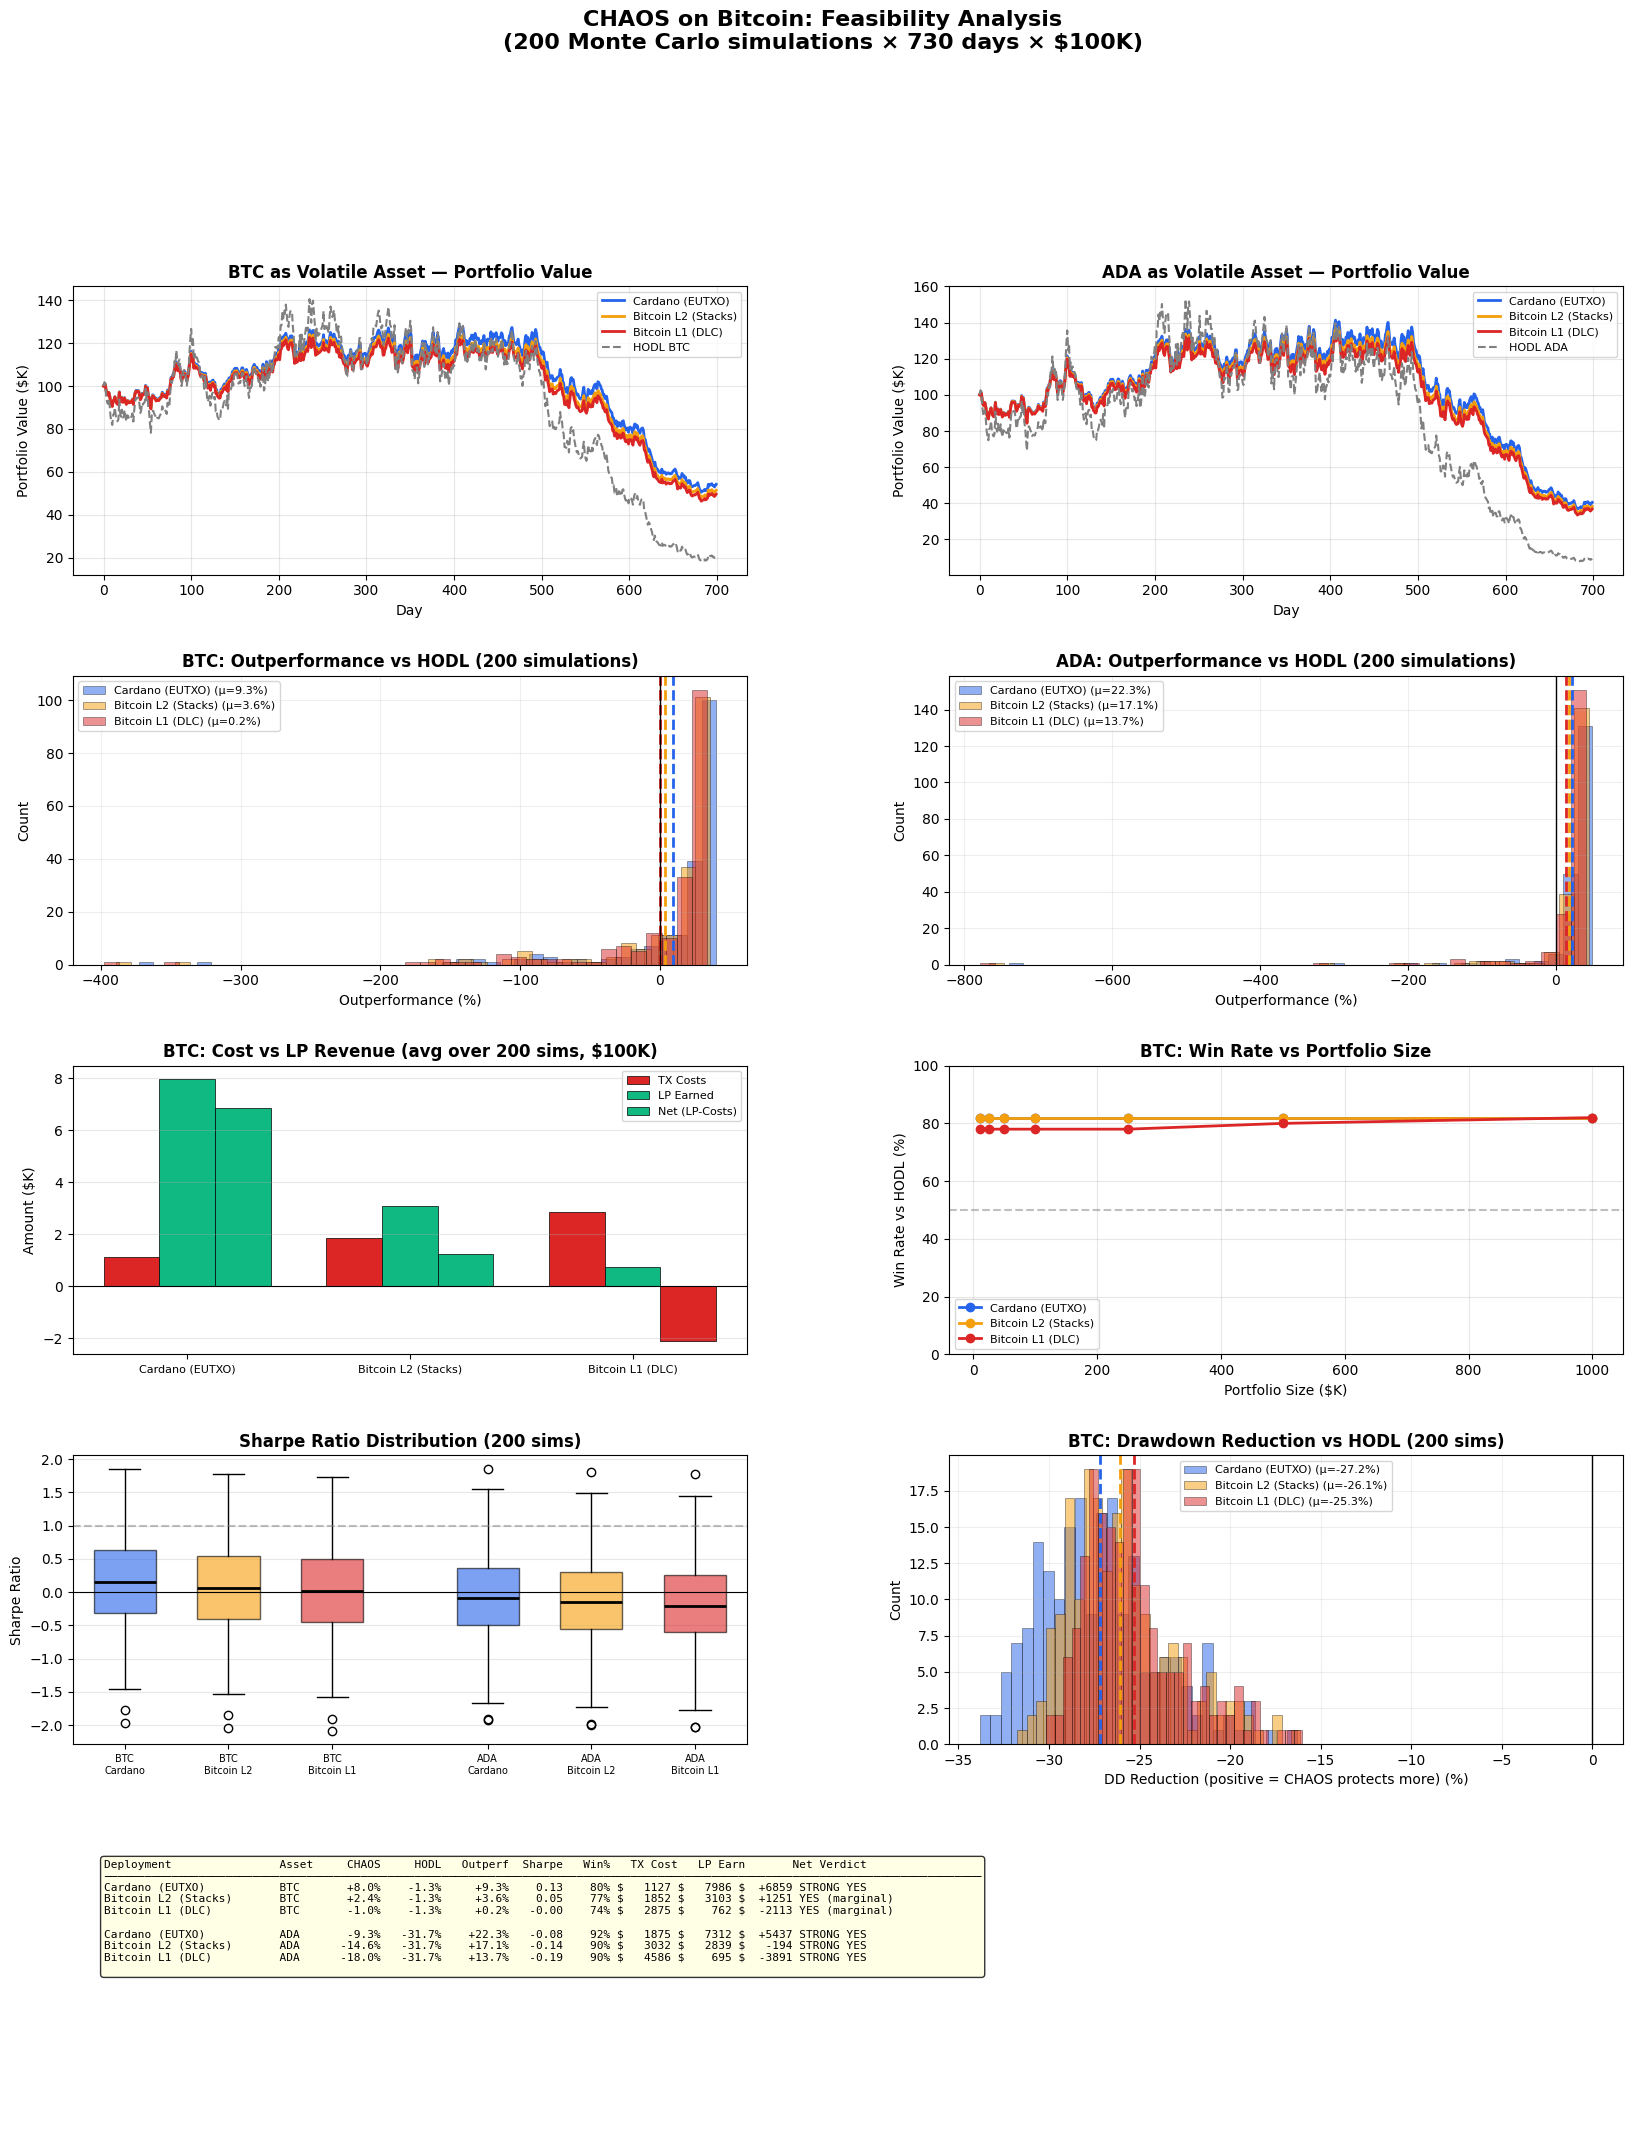

In [2]:
main()